In [35]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Define the parameters
N = 100     # number of nodes
d = 5       # degree
r = 0.1    # b/a

def ab (d, r):
    a = (2. * d) / (1. + r)
    b = a * r
    return a, b

a, b = ab(d, r)

print(f'd = {d}')
print(f'r = {r:.4f}')
print(f'r_c = {(np.sqrt(d)-1)/(np.sqrt(d)+1):.4f}')
print(f'a = {a:.4f}')
print(f'b = {b:.4f}')

d = 5
r = 0.1000
r_c = 0.3820
a = 9.0909
b = 0.9091


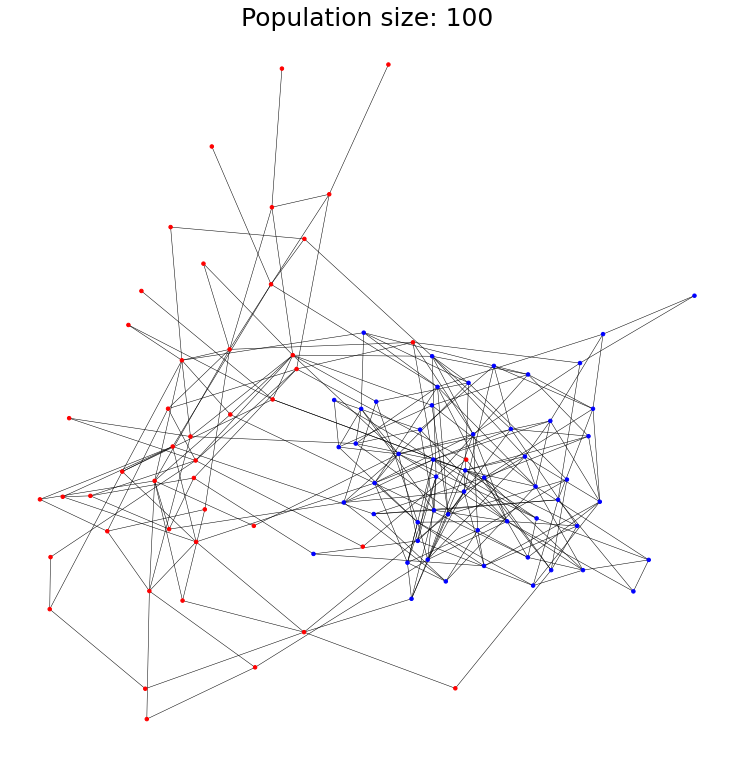

In [76]:
# Initialize random seed
#np.random.seed(0)

# Generate random state
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

# Simulations

In [77]:
nexp = 100   # Number of experiments
T = 4000    # Number of steps

## Metropolis

In [78]:
def run_metropolis(A, a, b, num_exp, T):
    Q = np.empty((num_exp, T))
    mc = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc.reset()
        for i in range(T):
            mc.step()
            Q[n, i] = compute_overlap(x_star, mc.x)
    return Q

In [79]:
def draw_plots(Q):
    plt.figure()
    plt.plot(Q[:,-1])
    plt.xlabel('Experiment')
    plt.ylabel('q')
    plt.title('Limiting Overlap Over Expermients');
    
    avg = np.average(Q, axis=0)
    plt.figure()
    plt.plot(avg)
    plt.xlabel('t')
    plt.ylabel('q')
    plt.ylim(top=1.)
    plt.title('Average Overlap Over Time');
    
    print(f'Average limiting overlap: {avg[-1]:.4f}')

In [80]:
Q = run_metropolis(A, a, b, nexp, T)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.17it/s]


Average limiting overlap: 0.9214


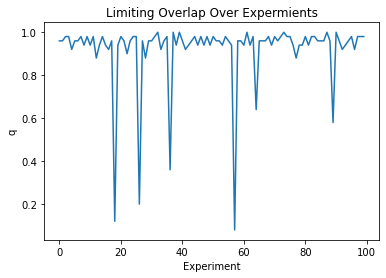

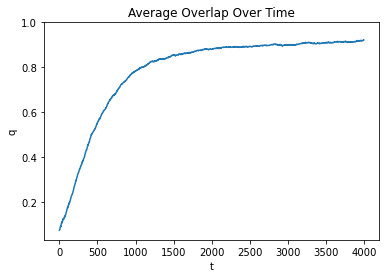

In [81]:
draw_plots(Q)

## Houdayer-1 

In [77]:
def run_houdayer(A, a, b, num_exp, T, n0):
    Q1 = np.empty((num_exp, T))
    Q2 = np.empty((num_exp, T))
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc1.reset()
        mc2.reset()
        for i in range(T):
            if i % n0 == 0:
                # Houdayer step
                x1, x2 = houdayer_step(G, mc1.x, mc2.x)
                mc1.x = x1
                mc2.x = x2
            mc1.step()
            mc2.step()
            Q1[n, i] = compute_overlap(x_star, mc1.x)
            Q2[n, i] = compute_overlap(x_star, mc2.x)
    return Q1, Q2

In [78]:
Q1, Q2 = run_houdayer(A, a, b, nexp, T, n0=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Average limiting overlap: 0.9029


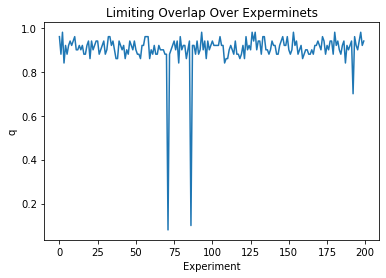

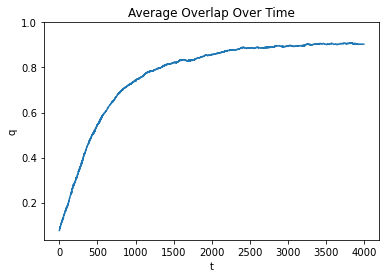

In [79]:
Q = np.vstack((Q1, Q2))
draw_plots(Q)

## Houdayer-10

In [80]:
Q1, Q2 = run_houdayer(A, a, b, nexp, T, n0=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Average limiting overlap: 0.9111


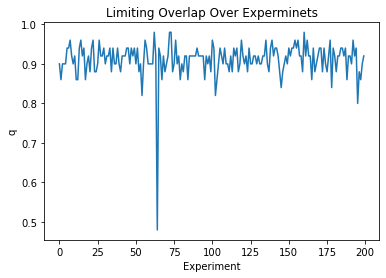

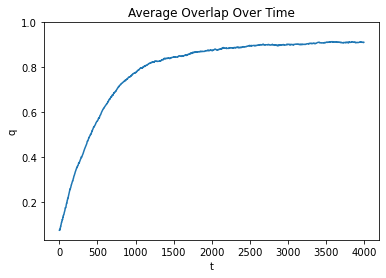

In [81]:
Q = np.vstack((Q1, Q2))
draw_plots(Q)

## Computing the Convergence time of the different algorithms

In [124]:
# Parameters
N = 500
d = 5
r_c = (np.sqrt(d)-1)/(np.sqrt(d)+1)
r = 0.1
a, b = ab(d, r)
print(f'r_c = {r_c:.4f}')

# random population and graph
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

r_c = 0.3820


In [125]:
epsilon = 0.1 # precision required for convergence
nexp_conv = 15

def conv_time_metropolis(A, a, b, num_exp):
    avg_Time = 0
    mc = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc.reset()
        T = 0
        while 1 - compute_overlap(x_star, mc.x) >= epsilon:
            mc.step()
            T += 1
        avg_Time += T
    return round(avg_Time / num_exp)

def conv_time_houdayer(A, a, b, num_exp, n0):
    avg_Time = 0
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc1.reset()
        mc2.reset()
        T = 0
        while 1 - (compute_overlap(x_star, mc1.x) + compute_overlap(x_star, mc2.x)) / 2 >= epsilon:
            if T % n0 == 0:
                # Houdayer step
                x1, x2 = houdayer_step(G, mc1.x, mc2.x)
                mc1.x = x1
                mc2.x = x2
            # Metropolis step
            mc1.step()
            mc2.step()
            T += 1
        avg_Time += T
    return round(avg_Time / num_exp)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Convergence time for Metropolis: 7558


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Convergence time for Houdayer 1: 12155


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.70s/it]

Convergence time for Houdayer 10: 10536


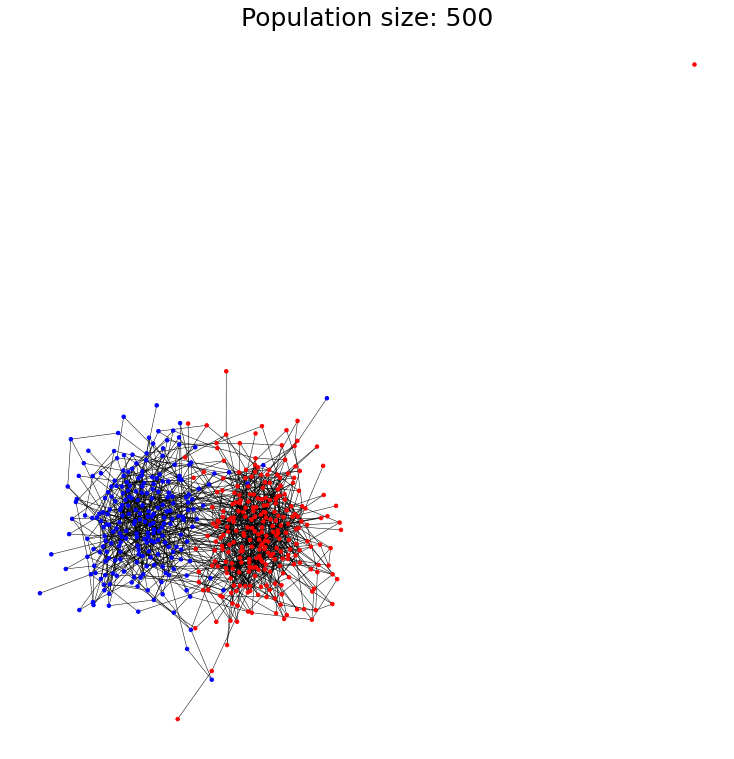

In [127]:
draw_graph(G, x_star)

print("Convergence time for Metropolis: {}".format(conv_time_metropolis(A, a, b, nexp_conv)))
print("Convergence time for Houdayer 1: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=1)))
print("Convergence time for Houdayer 10: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=10)))

## Limiting performance for different values of r

In [51]:
# Parameters
N = 700
d = 3
r_c = (np.sqrt(d)-1)/(np.sqrt(d)+1)
print(f'r_c = {r_c:.4f}')

# random population
x_star = generate_population(N)    

r_c = 0.2679


In [49]:
def perf_metropolis(A, a, b, num_exp, T):
    mc = Metropolis(A, a, b)
    running_overlap= 0.
    for n in range(num_exp):
        mc.reset()
        mc.step(T)
        running_overlap += compute_overlap(x_star, mc.x)
    return running_overlap / num_exp

def perf_houdayer(A, a, b, num_exp, T, n0):
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    running_overlap= 0.
    for n in range(num_exp // 2):
        mc1.reset()
        mc2.reset()
        for i in range(T):
            if i % n0 == 0:
                # Houdayer step
                x1, x2 = houdayer_step(G, mc1.x, mc2.x)
                mc1.x = x1
                mc2.x = x2
            # Metropolis step
            mc1.step()
            mc2.step()
        overlap1 = compute_overlap(x_star, mc1.x)
        overlap2 = compute_overlap(x_star, mc2.x)
        running_overlap += overlap1 + overlap2
    return running_overlap / num_exp

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:00<00:00, 120.06s/it]


Text(0.5, 1.0, 'limiting perfomance over several experiments')

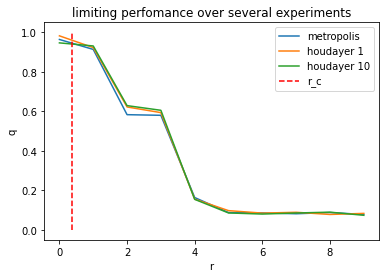

In [50]:
# Values of r to be tested
r_list = np.linspace(0.01, 1, num=10, endpoint=False)

# Computing the average overlap for each value of r and over several experiments
q_metr_lim = []
q_h1_lim = []
q_h10_lim = []
for r in tqdm(r_list):
    a, b = ab(d, r)
    G = graph_gen(x_star, a, b)
    A = nx.to_numpy_array(G)
    # Adding the limiting overlap for this value of r
    q_metr_lim.append(perf_metropolis(A, a, b, nexp, T))
    q_h1_lim.append(perf_houdayer(A, a, b, nexp, T, n0=1))
    q_h10_lim.append(perf_houdayer(A, a, b, nexp, T, n0=10))

Text(0.5, 1.0, 'limiting perfomance over several experiments')

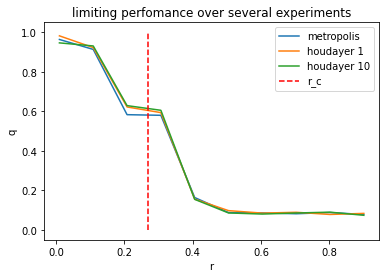

In [97]:
# Plotting the limiting perfomance as a function of r
plt.figure(figsize=(8, 8))
plt.plot(r_list, q_metr_lim)
plt.plot(r_list, q_h1_lim)
plt.plot(r_list, q_h10_lim)
plt.plot([r_c, r_c], [0, 1], 'r--', ) # plotting the phase transition
plt.legend(["metropolis", "houdayer 1", "houdayer 10", "r_c"])
plt.xlabel("r")
plt.ylabel("q")
plt.title("limiting perfomance over several experiments", fontdict={"fontsize":25})